COMPUTER EXERCISE 4

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import svd, inv, norm, solve, matrix_rank
from scipy.io import loadmat
import cv2
from mpl_toolkits.mplot3d import Axes3D

def compute_camera_candidates(E):
    """
    Given an essential matrix E, compute the four possible (R, t) camera matrices.
    """
    # SVD of E
    U, S, Vt = np.linalg.svd(E)

    # Ensure det(UV^T) = +1
    if np.linalg.det(U @ Vt) < 0:
        U[:, -1] *= -1  # Flip sign of last column of U

    # Rotation matrices
    W = np.array([[0, -1, 0],
                  [1,  0, 0],
                  [0,  0, 1]])

    # Translation is the third column of U
    u3 = U[:, 2]

    # Four possible (R, t) pairs
    candidates = [
        (U @ W @ Vt,  +u3),
        (U @ W @ Vt,  -u3),
        (U @ W.T @ Vt, +u3),
        (U @ W.T @ Vt, -u3)
    ]
    return candidates


In [47]:
def triangulate_point_dlt(P1, P2, x1, x2):
    """
    Triangulate a single 3D point given its 2D projections in two images.
    """
    A = np.array([
        x1[0] * P1[2] - x1[2] * P1[0],
        x1[1] * P1[2] - x1[2] * P1[1],
        x2[0] * P2[2] - x2[2] * P2[0],
        x2[1] * P2[2] - x2[2] * P2[1]
    ])

    _, _, Vt = np.linalg.svd(A)
    X = Vt[-1]  # Last row of Vt is the solution
    return X / X[-1]  # Normalize (make last coordinate 1)
def count_points_in_front(P, X):
    """
    Count the number of 3D points in front of the camera.
    """
    proj = P @ X
    return np.sum(proj[2, :] > 0)  # Count how many have positive Z

def select_best_camera(P1, candidates, x1, x2):
    """
    Triangulate points for each candidate P2 and find the best one.
    """
    best_P2 = None
    best_X = None
    max_in_front = -1

    for R, t in candidates:
        P2 = np.hstack((R, t.reshape(3, 1)))

        # Triangulate points
        X = np.array([triangulate_point_dlt(P1, P2, x1[:, i], x2[:, i]) for i in range(x1.shape[1])]).T

        # Count points in front of both cameras
        count_front = count_points_in_front(P1, X) + count_points_in_front(P2, X)

        if count_front > max_in_front:
            max_in_front = count_front
            best_P2 = P2
            best_X = X
    if best_P2[2, 3] != 0:
        best_P2 /= best_P2[2, 3]

    print("[DEBUG] Normalized best_P2:\n", best_P2)

    return best_P2, best_X



def plot_reprojection_error2(P, x, X, img, text):
    """
    Plot the original 2D points and the reprojected 3D points on the image.
    """
    # Project 3D points onto the image
    x_reproj = P @ X
    x_reproj /= x_reproj[2, :]  # Convert to inhomogeneous (scale by third row)

    # Create figure BEFORE plotting the image
    plt.figure(figsize=(8, 6))
    plt.imshow(img, cmap='gray')  # Display image as background

    # Plot original 2D points (actual feature matches)
    plt.scatter(x[0, :], x[1, :], color='blue', label='Original Points', s=10)

    # Plot reprojected 3D points onto 2D image
    plt.scatter(x_reproj[0, :], x_reproj[1, :], color='red', marker='x', label='Reprojected Points', s=3)

    # Set image bounds
    h, w, _ = img.shape
    plt.xlim([0, w])  # Image width
    plt.ylim([h, 0])  # Image height (flip y-axis for image coordinates)

    plt.title(f"Original vs. Projected 3D Points {text}")
    plt.legend()
    plt.show()


def plot_3d_scene(X, P1, P2):
    """
    Plot the 3D points and camera positions in a 3D space.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Convert homogeneous to inhomogeneous
    X = X[:3, :] / X[3, :]

    ax.scatter(X[0], X[1], X[2], marker='o', color='b', label="3D Points")

    # Compute camera centers
    C1 = np.array([0, 0, 0])  # Since P1 = [I | 0]
    R2 = P2[:, :3]
    t2 = P2[:, 3]
    C2 = -R2.T @ t2  # Camera center for P2

    ax.scatter(*C1, color='r', marker='^', label="Camera 1")
    ax.scatter(*C2, color='g', marker='^', label="Camera 2")

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("3D Reconstruction")
    ax.legend()
    plt.show()


[DEBUG] Normalized best_P2:
 [[ 1.73097301  0.75134359  2.04491256  2.56629867]
 [ 0.78009989 -2.65238964  0.31420615  0.39568075]
 [ 2.03411621  0.37784144 -1.86066097  1.        ]]


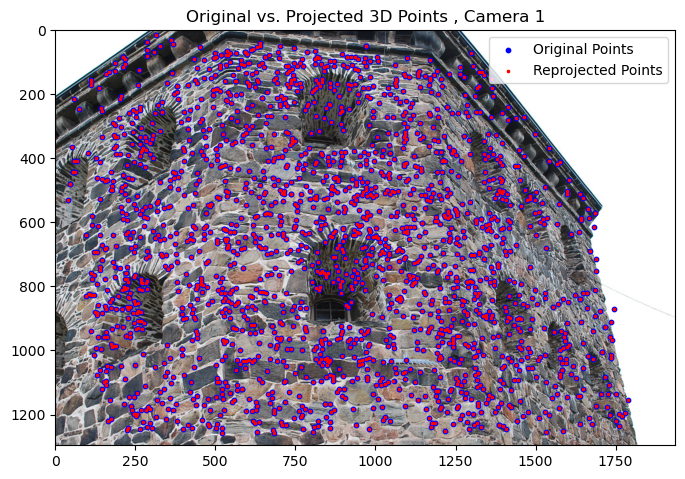

[DEBUG] Normalized best_P2:
 [[ 1.73097301  0.75134359  2.04491256  2.56629867]
 [ 0.78009989 -2.65238964  0.31420615  0.39568075]
 [ 2.03411621  0.37784144 -1.86066097  1.        ]]


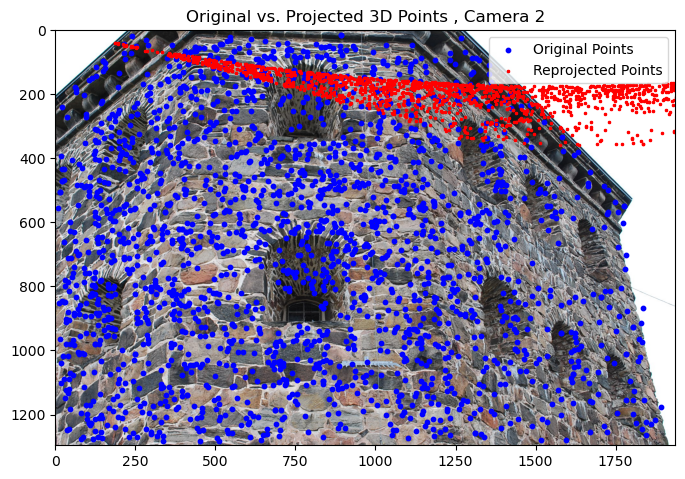

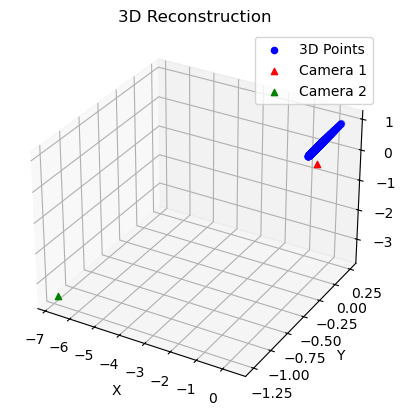

In [ ]:

data = loadmat('compEx3data.mat')
K = data['K']
data = loadmat('compEx1data.mat')
x = data['x']  
x1 = x[0, 0]  # First set of points (homogeneous 3×N)
x2 = x[1, 0]
# Load the image
image_filename = 'kronan2.jpg' # Change this to the other image when done
img = cv2.imread(image_filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

P1 = np.hstack((np.eye(3), np.zeros((3, 1))))
P1 = K @ P1  # Convert to unnormalized coords

candidates = compute_camera_candidates(E)
best_P2, best_X = select_best_camera(P1, candidates, x1, x2)
plot_reprojection_error2(best_P2, x2, best_X, img, ", Camera 2")


plot_3d_scene(best_X, P1, best_P2)



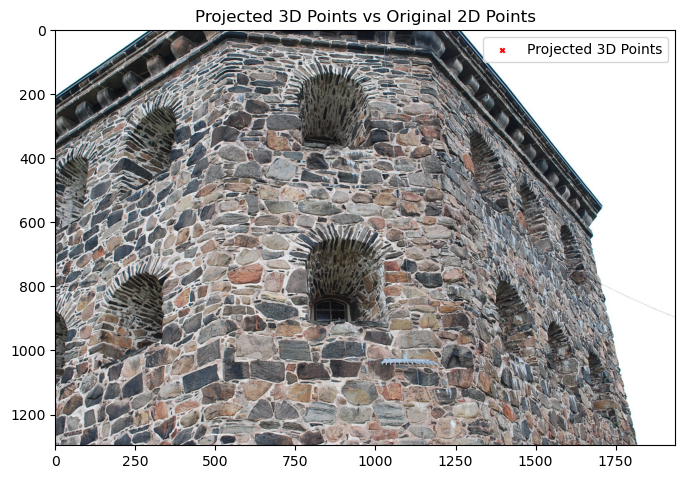

In [32]:
# Convert to un-normalized coordinates
#P1 = K @ P1
x_reproj = P1 @ best_X
x_reproj /= x_reproj[2]  # Convert to inhomogeneous


best_P2 = K @ best_P2

# Project the 3D points onto Image 
x2_projected = best_P2 @ best_X
x2_projected /= x2_projected[2, :]  # Convert to inhomogeneous

# ---- Plot image with original and projected points ----
plt.figure(figsize=(8, 6))
plt.imshow(img)  # Show image as background
#plt.scatter(x2[0, :], x2[1, :], color='blue', label='Original 2D Points', s=10)
plt.scatter(x_reproj[0, :], x_reproj[1, :], color='red', marker='x', label='Projected 3D Points', s=10)

plt.xlim([0, img.shape[1]])  # Image width
plt.ylim([img.shape[0], 0])  # Flip y-axis for image coordinates

plt.title("Projected 3D Points vs Original 2D Points")
plt.legend()
plt.show()